# Attention map visualization

In [1]:
import re
import random

import torch
from pathlib import Path
import matplotlib.pyplot as plt

from arithmetic_lm.model import TransformerDecoder, load_model, find_latest_ckpt
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.interp import plot_attn_maps
from arithmetic_lm.constants import PLOTS_DIR, CHECKPOINTS_DIR

import warnings

warnings.filterwarnings("ignore")

In [2]:
tokenizer = CharTokenizer()

## Select models

In [40]:
ckpts = {
    # === generalize-to-longer ===
    # "abs_pe_shift": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_10abspeshift/step750000-train_loss1.4077-val_loss1.4930.ckpt",
    # "nope": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_nope/step284000-train_loss1.4530-val_loss1.8758.ckpt",
    # "pre_matching": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_pre_matching_v1/step400000-train_loss1.4351-val_loss1.4716.ckpt",
    # "rope": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_rotary/step116000-train_loss1.4557-val_loss2.7940.ckpt",
    # "reversed": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_abs_ansrev",
    # "normal": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head",
    "rand_spaces_0.3": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_rand_spaces_0.5",
    # "rand_spaces_0.3": "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_rand_spaces_0.3",
    # === strlen_v1 ===
    # "string_length": "../checkpoints/strlen_v1/trans_dec_1layers_192embd_2head",
}

ckpts = {k: find_latest_ckpt(v) for k, v in ckpts.items()}

In [41]:
subdir = PLOTS_DIR / "gen_to_longer_rand_spaces"
subdir.mkdir(exist_ok=True)

True answer: 3$
pred_answer: 3$
transformer_encoder.layers[0].self_attn torch.Size([1, 4, 10, 10])
transformer_encoder.layers[1].self_attn torch.Size([1, 4, 10, 10])
transformer_encoder.layers[2].self_attn torch.Size([1, 4, 10, 10])
transformer_encoder.layers[3].self_attn torch.Size([1, 4, 10, 10])
transformer_encoder.layers[4].self_attn torch.Size([1, 4, 10, 10])
transformer_encoder.layers[5].self_attn torch.Size([1, 4, 10, 10])


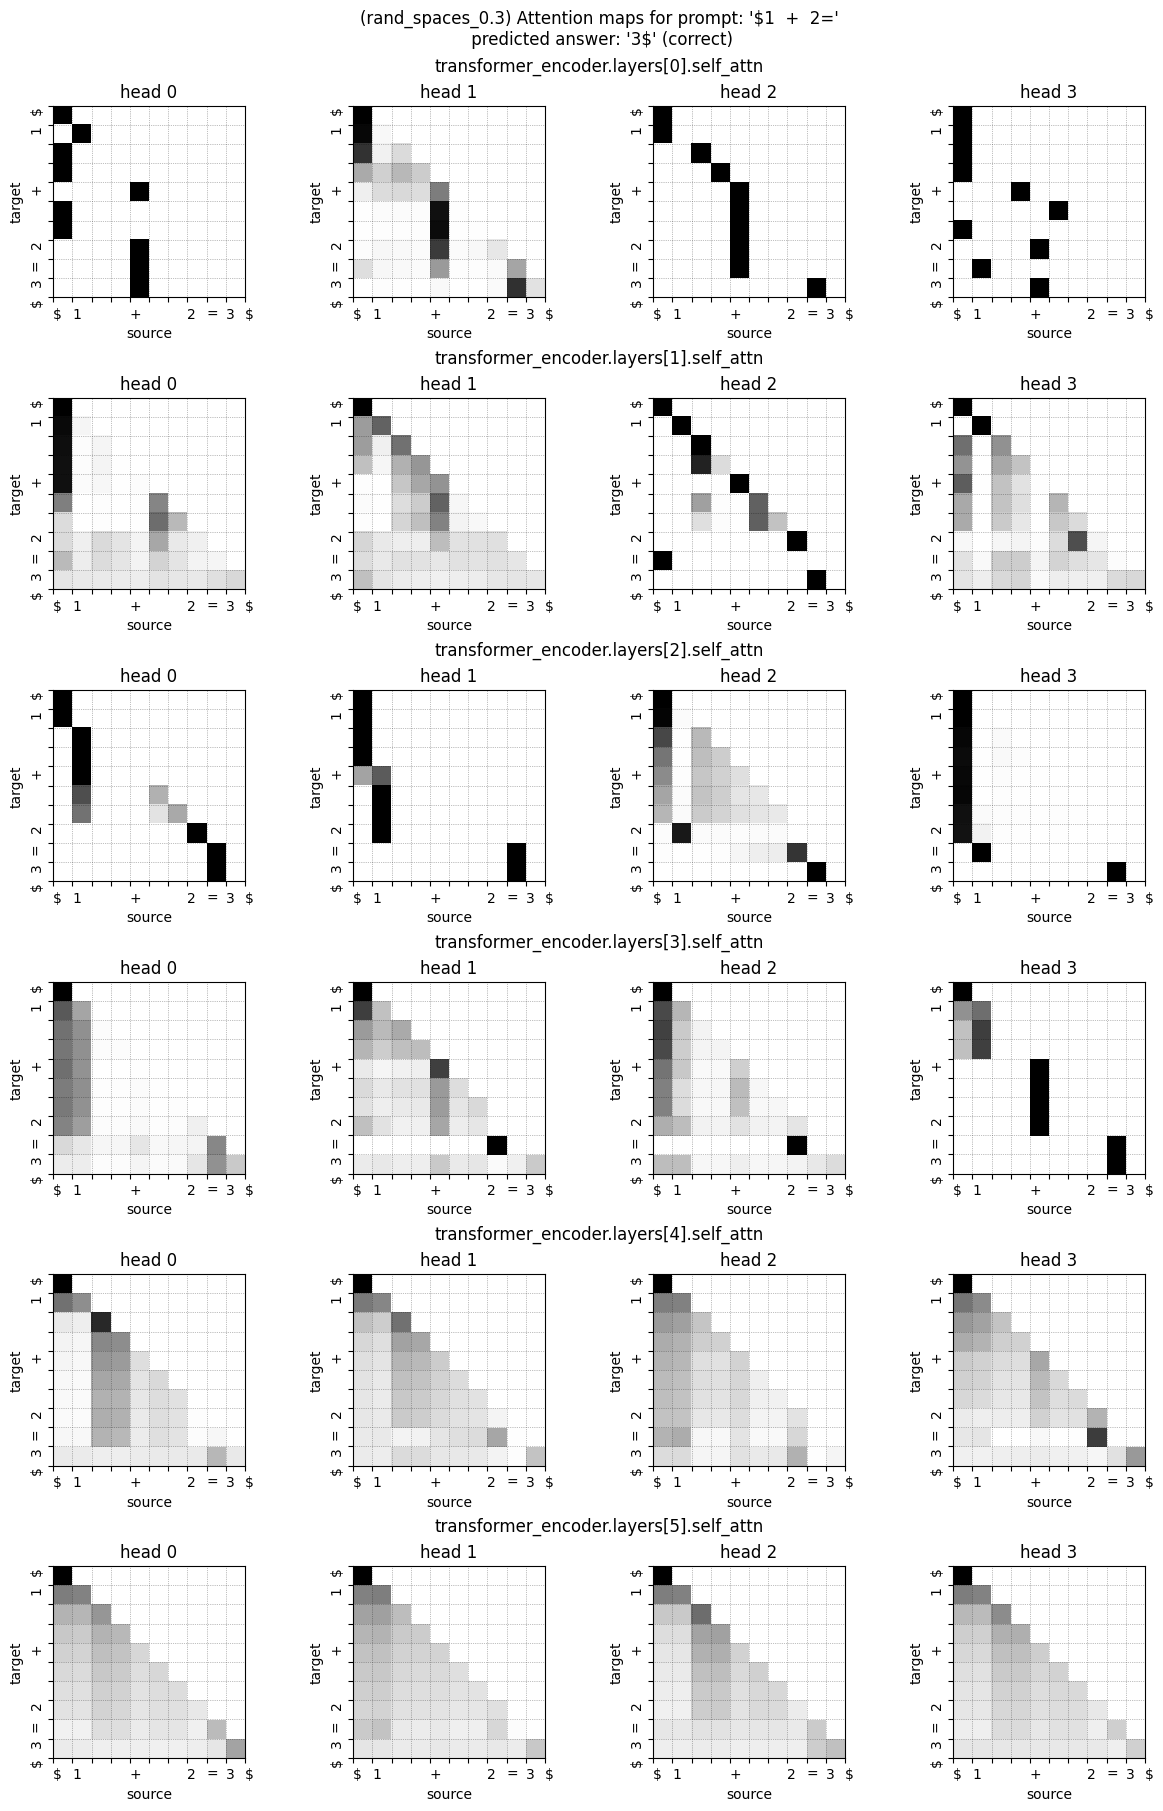

In [45]:
# general tasks

fig_scale = 3

prompt_str = "$1  +  2="
true_ans = (
    str(eval(prompt_str.replace("=", "").replace("$", "").replace(" ", ""))) + "$"
)
print(f"True answer: {true_ans}")

for model_name, ckpt_path in ckpts.items():
    model, hparams = load_model(ckpt_path)
    reverse_ops = hparams["extra_hparams"]["data_format"]["reverse_ops"]
    reverse_ans = hparams["extra_hparams"]["data_format"]["reverse_ans"]
    filler_tokens_prompt = hparams["extra_hparams"]["data_format"][
        "filler_tokens_prompt"
    ]

    module_names = [mn for mn, _ in model.named_modules() if mn.endswith("self_attn")]
    # replace index to get correct syntax
    module_names = [re.sub(r"\.(\d+)\.", r"[\1].", mn) for mn in module_names]

    savepath = subdir / f"spaces_add_{len(prompt_str)}_{true_ans}_{model_name}.png"
    kwargs = dict(
        tokenizer=tokenizer,
        prompt_str=prompt_str,
        true_ans=str(true_ans),
        module_names=module_names,
        fig_scale=fig_scale,
        save=True,
    )
    attn_maps = plot_attn_maps(
        model=model,
        savepath=str(savepath),
        figtitle_prefix=f"({model_name})",
        **kwargs,
    )